<a href="https://colab.research.google.com/github/Buchunwang/UK-CLI/blob/main/kim_nelson_uk_data_28_07_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**This code is replication of Kim&Nelson (1998) with UK data**
---



---
**Brief introduction of the code:**\
This is a Bayesian algorithm with three main blocks: \
1. Kalman filter
2. Hamilton(1989) basic filter
3. Estiamting parameters by multi-move Gibbs sampling.

We iteratively run the process 1→2→3→1→2→3→1…

---



---


From the algorithm, we can generate:
1. a new economic index of UK
2. historical recession period of UK
3.In the end, we will also display the distribution of all the parameters.

---

---





**Data**\
First three columns are first order of original UK composite leading indicator(CLI) with 0 lag, 1 lag and 2 lags: $\Delta c_t$, $\Delta c_{t-1}$ , $\Delta c_{t-2}$.\
For column 4:8, they are component variables $\Delta y_i, i=1,2,3,4,5$ applied to generate original CLI.\
 There were 6 component variables in totoal, but we removed new driver number every year as the data is not suitable for this model without etxra modificaions.\
Column 9:13,13:18 are component variables with 1 lag and 2 lags individually:$\Delta y_{i_{t-1}} \& \ \Delta y_{i_{t-2}}, i=1,2,3,4,5$.

All data imported have been detrended.

Name of $Y_i$ :

1. Retail Prices Index - All Items Index
2. Consumer survey - confidence indicator
3.  GBP interbank LIBOR 3 months delayed of UK  inverted
4.  Manufacturing survey - production: future tendency sa (season adjusted)
5.  Share prices: FTSE LOCAL UK ($£ $) index

Data source: OECD

---



---



In [1]:
import os
import pandas as pd
import numpy as np
url = 'https://raw.githubusercontent.com/Buchunwang/UK-CLI/main/Kalman%20filter/kalpre.csv'
print('From URL:', url)
kalpre1 = pd.read_csv(url, header=None, encoding='utf-8', skiprows=1)

From URL: https://raw.githubusercontent.com/Buchunwang/UK-CLI/main/Kalman%20filter/kalpre.csv


**Functions**

---


There are 3 functions we are going to use:
1.  Kalman Filter (regime-switching state-space Kalman filter)
2.  Update process afetr Kalman filter using t+1 data for time t
2.  Posterior normal distribution
3.  Posterior inverse Gamma distribution

In [2]:
import numpy as np
from scipy.stats import norm, gamma, beta
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from numpy.random import normal
import pandas as pd
import warnings
def Kalman(R,H,A,Q_kal,true5D,Mu_st,N,P,K):
# kalman filter for 5D data
    k = 0
    for t in range(N-1):
        k += 1
        x[:, k] = np.dot(A, x[:, k-1])+Mu_st[:,k]    # Kalman equation 1
        P = np.dot(A, np.dot(P, A.T)) +Q_kal #np.dot(B,np.dot(Q,B.T))  # Kalman equation 2
        K = np.dot(P, np.dot(H.T, np.linalg.inv(np.dot(H, np.dot(P, H.T)) + R)))  # Kalman equation 3
        z[:, k] = [true5D[0, k], true5D[1, k], true5D[2, k], true5D[3, k], true5D[4, k]]
        x[:, k] = x[:, k] + np.dot(K, (z[:, k] - np.dot(H, x[:, k])))  # Kalman equation 4
        P = np.dot((np.eye(P.shape[0]) - np.dot(K, H)), P)  # Kalman equation 5
        vct[0, k] = P[0, 0]  # save variance of delta_ct
      #  vct[1, k] = P[1, 1] we won't use second and third row
       # vct[2, k] = P[2, 2]
    return K, x, vct

def afterkal(x,vct,Q_kal,phi,c):# add t+1 data to information set
    for ii in range(N-2):  # this loop is just for xi_t and V_t conditional on delta_ct+1 for t=1,2,...,T-1
        eta = c - phi[0]*x[0, N-ii-2] - phi[1]*x[0, N-ii-3] - phimu_st[N-ii-1]  # value of eta_t two lag in my model, that's why I have term -phi(2)*x(2,N-i)
        Rt = phi[0]**2*vct[0, N-ii-1]+phi[1]**2*vct[0,N-ii-2]+var_vt
        xi[0, N-ii-2] = x[0, N-ii-2] + (phi[0]*vct[0, N-ii-2]+phi[1]*vct[0,N-ii-3])*eta/Rt
    # we only use first row of the mean and variance vector
    # so I calculated the first element of each mean & variance directly
        V[0, N-ii-2] = vct[0, N-ii-2] - (phi[0]**2 * (vct[0,N-ii-2]**2)+phi[1]**2*(vct[0,N-ii-3]**2)) / Rt
        c = normal(xi[0, N-ii-2], np.sqrt(V[0, N-ii-2]))
    V[0, N-1] = vct[0, N-1]# V_T didn't get upgraded, it's still from step 1
    xi[0, N-1] = x[0, N-1]# xi_T didn't get upgraded, it's still from step 1
    return xi,V


def posteriornormal(mean,var,a,b):

    if np.isscalar(mean) and np.isscalar(var):
        mean = 1/(1/var+a) * (mean/var + b )
        var  = 1/(1/var+a)

    else:
        mean = np.linalg.inv(np.linalg.inv(var)+a) @ (np.linalg.inv(var) @ mean + b )
        var  = np.linalg.inv(np.linalg.inv(var)+a)
    if np.isnan(mean).any(): # if NaN shows up,reset to initial value
        mean = np.zeros(mean.shape)
        var = np.eye(var.shape[0])
    return mean, var





def posteriorIG(a,b):
    sig=1 / np.random.gamma(a, 1/b)
    return(sig)






---


**Modeling of the algorithm**

---

1.
\begin{equation}
\Delta Y_{it}=\lambda_i(L)\Delta C_t+D_i+e_{it} \ \ \ i=1,2,3,4,5 \ \ \ t=1,2… T
\end{equation}
$Y_{it}$ are component series above except passenger car registrations,$C_t$ is the growth rate of CLI,
$\lambda _i(L)=\lambda _i $ here for simplicity.






2.

\begin{equation}
\Psi_i(L)e_{it}=\epsilon_{it},  \ \ \ \epsilon_{it}\sim iid N(0,\sigma_i^2)	  
\end{equation}
where $\Psi_i(L)=1-\psi_{i1}L-\psi_{i2}L^2$, $L$ is the lag operator

3.
\begin{equation}
\Phi(L)(\Delta C_t-\mu_{s_t}-\delta
)=v_t\ \ \ \ \ \ \ \ \ \ v_t\sim iid N(0,σ^2_{vt})
\end{equation}
where $\Phi(L)=1-\phi_1L-\phi_2L^2$. $\mu_{s_t}-\delta$ is the mean growth rate of $\Delta C_t$, $\mu_{s_t}$ is the regime-switching component.



4.

\begin{equation}
	\mu_{s_t}=\mu_0+\mu_1S_t
\end{equation}
where $S_t=\{\begin{matrix}
		0,1
	\end{matrix}\}$
 and $\mu_1<0$.
The regime-switching happens at the mean value of $\Delta C_t$.


With all parameters ready, we can then form matrices of the state-space model for Kalman filter
\begin{equation}
	\Delta y^*_t=H^*\zeta_t+\epsilon_t
\end{equation}
\begin{equation}
	\zeta_t=\tilde M^*_{s_t}+F^*\zeta_{t-1}+u^*_t
\end{equation}
which can be expanded as  

\begin{equation}
\begin{bmatrix}
	\Delta y^*_{1t}\\ \Delta y^*_{2t}\\ \Delta y^*_{3t}\\ \Delta y^*_{4t}\\ \Delta y^*_{5t}
\end{bmatrix}
=
\begin{bmatrix}
	\lambda_1&\ \  -\lambda_i\psi_{11}&\ \ -\lambda\psi_{12}\\
	\lambda_2&\ \ -\lambda_i\psi_{21}&\ \ -\lambda\psi_{22}\\
	\lambda_3&\ \ -\lambda_i\psi_{31}&\ \ -\lambda\psi_{32}\\
	\lambda_4&\ \ -\lambda_i\psi_{41}&\ \ -\lambda\psi_{42}\\
	\lambda_5&\ \ -\lambda_i\psi_{51}&\ \ -\lambda\psi_{52}\\
\end{bmatrix}
\begin{bmatrix}
	\Delta c_t\\ \Delta c_{t-1} \\ \Delta c_{t-2}
\end{bmatrix}
+
\begin{bmatrix}
	\epsilon_{1t}\\
	\epsilon_{2t}\\
	\epsilon_{3t}\\
	\epsilon_{4t}\\
	\epsilon_{5t}\\
\end{bmatrix}
\end{equation}
\begin{equation}
	\begin{bmatrix}
\Delta c_t\\ \Delta c_{t-1} \\ \Delta c_{t-2}
	\end{bmatrix}
	=
	\begin{bmatrix}
		\Phi(L)\mu_{s_t}\\
		0\\
		0
	\end{bmatrix}
	+\begin{bmatrix}
		\phi_1&\phi_2 & 0\\
		1&0&0\\
		0&1&0
	\end{bmatrix}
	\begin{bmatrix}
	\Delta c_{t-1}\\ \Delta c_{t-2} \\ \Delta c_{t-3}
	\end{bmatrix}
	+
	\begin{bmatrix}
		v_t\\ 0 \\ 0
	\end{bmatrix}
\end{equation}


Before standardizing the data, mean value of $\Delta y_i$ needs to be calculated first. Otherwise $E(\Delta y_i)$ would all be 0.

Then we set intial values for the model. The choice of initial value all follows the seting of Kim \& Nelson (1998).
Initial setting including:

1.   input for Kalman filter
2.   initial value of all the parameters ψ_ij, λ_i,ϕ_j, σ_i, i=1,2,3,4,5,j=1,2
, p,q,δ
3.   iteration times, burn-in period and storage space for the samples
\
In this model, we will run the iteration 10000 times and only draw samples after first 2000 iterations. Frist 2000 iterations are burn-in period which will not be used because values from this part are not stable. According to Kim \& Nelson(1998)'s test, values will stablize after 2000 iterations
4. user-choose prior distribution for all the parameters. Priors are all fixed during calculation. The priors can be set freely.
Our prior setting follows K&N(1998):



\begin{equation*}
  λ _i \sim N(0,1) , i=1,2,3,4,5
\end{equation*}

\begin{equation*}
\ \ \ \ \ \ \ \ \ \ \psi_i \sim N(\begin{bmatrix} 0\\0 \end{bmatrix},\begin{bmatrix} 1&0\\0&1 \end{bmatrix}), i=1,2,3,4,5 \\
\end{equation*}

\begin{equation*}
\sigma_i\sim IG(0,0), i=1,2,3,4,5\\
\end{equation*}

\begin{equation*}
\mu \sim N(\begin{bmatrix} 0\\0 \end{bmatrix}, \begin{bmatrix} 1&0\\0&1 \end{bmatrix})\ \ \ \ \ \ \
\end{equation*}

\begin{equation*}
\phi \sim N(\begin{bmatrix} 0\\0 \end{bmatrix}, \begin{bmatrix} 1&0\\0&1 \end{bmatrix})\ \ \ \ \  \ \
\end{equation*}




In [10]:
##########################################################################
#          pre-setting
##########################################################################
import numpy as np
from scipy.stats import norm, gamma, beta
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from numpy.random import normal
import pandas as pd
import warnings
# Remove warning message of time series from each iteration
def custom_warning_handler(*args, **kwargs):
    pass

warnings.showwarning = custom_warning_handler

##########################################################################
#          iteration setting
##########################################################################
iter = 10000 # number of iterations
burn = 2000 #we burn the first 2000 iterations and sampling from the later 8000 iterations in the Monter Carlo


##########################################################################
#          input data
##########################################################################
# calculate the mean of y_i
#this should be done before standardizing the data
delta_y_mean = np.zeros((5,1))
for i in range(5):
    delta_y_mean[i,0] = np.mean(kalpre1.iloc[:, i + 2]) #used in generating delta in appendix 7

scale= StandardScaler()
kalpre = scale.fit_transform(kalpre1)#standardize data

np.random.seed(6) #fix randomness
# estimation results of parameters are different for different seeds

N = kalpre.shape[0] #length of input
Y = np.transpose(kalpre[:,3:9])#Y_{1t} to Y_{5t}
# Calculate delta_y, delta_y_t-1, and delta_y_t-2
# Yit-E(Y), remove the mean value
y = np.zeros((5, N))
y1lag = np.zeros((5, N))
y2lag = np.zeros((5, N))
for i in range(5):
    y[i-1, :] = kalpre[:, i + 2] - np.mean(kalpre[:, i + 2])
    y1lag[i-1, :] = kalpre[:, i + 7] - np.mean(kalpre[:, i + 7])
    y2lag[i-1, :] = kalpre[:, i + 12] - np.mean(kalpre[:, i + 12])
x = np.zeros((3, N))#empty matrix to save mean value of xi_t
vct = np.zeros((3, N))#empty matrix to save variance of xi_t

mu_st=np.zeros(N) #this is for kalman filter
xi=np.zeros((1,N))
V=np.zeros((1,N))
######################################################
# The following settings are for estimation of parameters in after hmailton basic filter

N=kalpre.shape[0]-2
rrighta3 = np.zeros((1, N - 2))#this matrix is for calculating distribution of lamda
Q = np.zeros((N - 4, 2))
Qstar = np.zeros((N - 4, 2))
fvarphi = np.array([[1, 0], [0, 1]])
mut = np.zeros(N)#corresponding regime for t=3 to N, this is for estimating parameters
meanlamda=np.zeros(5)
varlamda=np.zeros(5)
lamda=np.zeros(5)
sig=np.zeros(5)
vvarpsi==np.zeros((2,5))
mmeanpsi=np.zeros((2,5))



##########################################################################
# user-choose prior
##########################################################################
# variance and mean prior
varlamdap=1
meanlamdap=0
varpsip = np.eye(2)
meanpsip = np.zeros((2, 1))
sig_a=N/2
sig_b=0
#sigma_1~IG(sig1a,sig1b) inverse gamma distribution
# prior is just 0, because posterior is a fixed number :prior+N/2 which is just N/2, so we just set sig_i_a as N/2 here
# if want different prior such as m, let sig1a=...=sig5a=m+N/2
varmup=varphip = np.eye(2)
meanmup=meanphip = np.zeros((2,1))


##########################################################################
# form storage space
##########################################################################
# Output
# We set some empty matrices here to save values from each iteration
# After the 2000 burn-in period, we need to save value for later 80000 iterations
vlamda=np.zeros((iter-burn,5))
mlamda=np.zeros((iter-burn,5))
bsig=np.zeros((iter-burn,5))
vpsi=np.zeros((iter-burn,10))
mpsi=np.zeros((iter-burn,10))
mphi=np.zeros((iter-burn,2))
vphi=np.zeros((iter-burn,2))
mmu=np.zeros((iter-burn,2))
vmu=np.zeros((iter-burn,2))
mmu1 = np.zeros(iter-burn)
mmu2 = np.zeros(iter-burn)
vmu1 = np.zeros(iter-burn)
vmu2 = np.zeros(iter-burn)
delta=np.zeros(iter-burn)
transition_prob_p=np.zeros(iter-burn)
transition_prob_q=np.zeros(iter-burn)
delta=np.zeros(iter-burn)




##########################################################################
# Initial input
##########################################################################
q = 0.9
p = 0.9
lamda=0.5*np.ones(5)
sig=0.2*np.ones(5)
psi=np.zeros((5,2))
phi=np.zeros(2)
mu0=-2
mu1=2.5

# Initialize the DataFrame with the size of 8x419 with NaNs
inputkal1 = pd.DataFrame(np.nan, index=range(N), columns=range(8))
# Fill the columns 4 to 8 with the data from 'kalpre'
inputkal1.iloc[:,3:8] = (y[:,2:421]).T # 419 values

N=kalpre.shape[0]

################################## Preparation for first iteration



##################################  initial St
#St=np.zeros(N) # as we are starting from kalman filter, St for kalman filter is 421
def generate_markov_chain(p, q, initial_state, N):
    # Initialize the Markov Chain
    markov_chain = np.zeros(N)
    markov_chain[0] = initial_state

    for i in range(1, N):
        if markov_chain[i-1] == 1:
            markov_chain[i] = np.random.choice([0, 1], p=[1-p, p])
        else:
            markov_chain[i] = np.random.choice([0, 1], p=[q, 1-q])

    return markov_chain
initial_state = 1  # initial state
St = generate_markov_chain(p, q, initial_state, N)
SSt=St
mu_st = mu0 * np.ones(N) + mu1 * np.ones(N) * St
phimu_st=np.zeros(N)
phimu_st = (np.array(mu_st[2:N])
            - np.array(mu_st[1:N-1]* phi[0])
            - np.array(mu_st[0:N-2]* phi[1]))
phimu_st = (np.array(mu_st[2:N])
            - np.array(mu_st[1:N-1]* phi[0])
            - np.array(mu_st[0:N-2]* phi[1]))
phimu_st = np.array(phimu_st)
phimu_st = np.insert(phimu_st, [0, 0], phimu_st[0])
Mu_st=np.zeros((3,N))
Mu_st[0,:]=phimu_st

new_delta_ct= np.zeros((N, 1))
sample_ct=np.zeros((N, 1))
regime=np.zeros((N, 1))
e_it=np.zeros((5,N)) # for e_it i=1,2,3,4,5 (it's used when calculating delta)
var_vt=1



# initial setting finishes here

##############################################################################


**Details of the algorithm**

---


---


---




In Gibbs sampling, we always use the most up-to-date information as input for each block of the Bayesian algorithm.

There are 3 main blocks: Kalman filter, Hamilton (1989) basic filter and paraeter estimation through multimove Gibbs sampling. We will introduce detail of each block and how to iteratively connect each block.


---


---


First step: Kalman filter\
input:
1.  parameters generated from last step's multimove Gibbd sampling
including $\Phi(L), \Psi_i(L), \mu_0,\mu_1,σ_i λ_i, i= 1,2,3,4,5$
2.  series $Δ y_{it}, i=1,2,3,4,5$

output: mean & variance of $Δ c_{t|t} , t=1, ⋯⋯, T-1, T$

Then we make use of t+1 data of $Δ c_{t|t}$ to update $Δ c_{t|t}$ based on Kalman filter equations

In the end of step 1: we get $Δ c_{t|t+1}$

---
\begin{equation}
	\Delta y^*_t=H^*\zeta_t+\epsilon_t
\end{equation}
\begin{equation}
	\zeta_t=\tilde M^*_{s_t}+F^*\zeta_{t-1}+u^*_t
\end{equation}
which can be expanded as  

\begin{equation}
\begin{bmatrix}
	\Delta y^*_{1t}\\ \Delta y^*_{2t}\\ \Delta y^*_{3t}\\ \Delta y^*_{4t}\\ \Delta y^*_{5t}
\end{bmatrix}
=
\begin{bmatrix}
	\lambda_1&\ \  -\lambda_i\psi_{11}&\ \ -\lambda\psi_{12}\\
	\lambda_2&\ \ -\lambda_i\psi_{21}&\ \ -\lambda\psi_{22}\\
	\lambda_3&\ \ -\lambda_i\psi_{31}&\ \ -\lambda\psi_{32}\\
	\lambda_4&\ \ -\lambda_i\psi_{41}&\ \ -\lambda\psi_{42}\\
	\lambda_5&\ \ -\lambda_i\psi_{51}&\ \ -\lambda\psi_{52}\\
\end{bmatrix}
\begin{bmatrix}
	\Delta c_t\\ \Delta c_{t-1} \\ \Delta c_{t-2}
\end{bmatrix}
+
\begin{bmatrix}
	\epsilon_{1t}\\
	\epsilon_{2t}\\
	\epsilon_{3t}\\
	\epsilon_{4t}\\
	\epsilon_{5t}\\
\end{bmatrix}
\end{equation}
\begin{equation}
	\begin{bmatrix}
\Delta c_t\\ \Delta c_{t-1} \\ \Delta c_{t-2}
	\end{bmatrix}
	=
	\begin{bmatrix}
		\Phi(L)\mu_{s_t}\\
		0\\
		0
	\end{bmatrix}
	+\begin{bmatrix}
		\phi_1&\phi_2 & 0\\
		1&0&0\\
		0&1&0
	\end{bmatrix}
	\begin{bmatrix}
	\Delta c_{t-1}\\ \Delta c_{t-2} \\ \Delta c_{t-3}
	\end{bmatrix}
	+
	\begin{bmatrix}
		v_t\\ 0 \\ 0
	\end{bmatrix}
\end{equation}

Before starting Kalman filter, we form all the matrix above. Also, $Δ y^*_{it}=\Psi_i(L)*Δ y_{it}$, we use new $\Psi_i(L)$ estimated from last iteration to form new $Δ y^*_{it}$ at the beginning of Kalman filter in every iteration.

---



The function of Kalman filter is to estimate mean and variance of $\zeta_t$, $\zeta_t=	\begin{bmatrix}
\Delta c_t\\ \Delta c_{t-1} \\ \Delta c_{t-2}
	\end{bmatrix} $.  

Algorithm of Kalman filter is show as follows

t iterates from t=2 to t=T

For each iteration t, we use t-1 as input. $\zeta_{t|t}$ from last iteration would become $\zeta_{t-1|t-1}$ for next iteration. $P_{t|t}$ from last iteration would become $P_{t-1|t-1}$ for next iteration.

1.
\begin{equation}
 \zeta_{t|t-1}=F^*\zeta_{t-1|t-1}+\tilde M^*_{s_t}
 \end{equation}
 Equation 1 is the process of **predicting** mean value of $\zeta_t $ from $\zeta_{t-1}$.  $\  \zeta_{t|t-1}=E[\zeta_t|t-1]=E[F*\zeta_{t-1}+\phi(L)\mu_{st}+v_t|t-1]=F*\zeta_{t-1}$ as $\mu_{st}$ is imposed mean zero in the setting according to Kim and Nelson (1998) and $v_t$ is iid noise of time t. For the first input $t=1$, we assume $\zeta_{1|1}=0$. This is extended version of normal state-space Kalman filter as we added state-dependent element $M_{st}$ in the first kalman filter equation.
   
2.
 \begin{equation}
 P_{t|t-1}=F^*P_{t-1|t-1}F^{*^T}+Q
 \end{equation}
 Equation 2 is the process of **predicting** variance of $\zeta_t $ from $\zeta_{t-1}$. $Q$ is the variance matrix of process noise $[v_t,\ v_{t-1},\ 0]'$.  

 3.
\begin{equation}
	K(t)= P_{t|t-1}H^{*^T}[H^*P_{t|t-1}H^{*^T}+R]^{-1}      
\end{equation}
Equation 3 is the process of **filtering** or upgrading. Through this equation we can obtain the value of Kalman gain $K$. Kalman gain would stablize after a few iterations (which is called as steady-state Kalman gain). This is caused by the stablized variance matrix $P$ after a few iterations.
  

4.
\begin{equation}
 \zeta_{t|t}= \zeta_{t|t-1}+K(t)([\Delta y^*_t-H^*\zeta_{t|t-1}]
\end{equation}
Equation 4 is the process of **filtering** mean value of $\zeta_t$ by adding the filtered error term at time t.
  

5.
\begin{equation}
	P_{t|t}=[I-K(t)H^*]P_{t|t-1}
\end{equation}
where $I$ is identity matrix.  
Equation 5 is the process of **filtering** variance of $\zeta_t$. $P$ would stablize with the stablization of Kalman gain after a few iterations.
  

---


We iteratively run the algorithm from equation 1 to 5 from $t=2$ to $t=N$ and in the end we would obtain the filtered mean and variance of $Δ c_{t|t}$ for $t=1\dots N$ from each iteration.

After Kalman filter, we make full use of the information to improve the estimation result of Kalman filter.

 Take $\Delta\ c_{t+1}$ as observation and run a backward iteration to improve the effect of estimation.

---

We take $\Delta c_{t+1}$ as extra observation and add  it to information set to lower the variance based on the following equation:
\begin{equation}
	p(\tilde{\zeta}_T|\Delta\tilde{y}^*_T)=p(\zeta_T|\Delta\tilde{y}^*_T)\mathop{\Pi}\limits^{T-1}_{t=1}p(\zeta _t|\Delta\tilde{y}^*_t,\zeta _{t+1})
\end{equation}
where joint distribution $\tilde{\zeta}_T=[\begin{matrix}
	\zeta_1 &\zeta_2& \cdots &\zeta_T
\end{matrix}]$' and $\tilde{y}_T=[\begin{matrix}
	y_1 &y_2& \cdots &y_T
\end{matrix}]$'.
\\ From last step, $\zeta _{t|t}$ and $V_{t|t}$ is obtained and we generated $\Delta c_T$. In this step, $\Delta c_t$ for $t=1,2,\cdots T-1$ is what we are going to generate. We follow \citet{kim} and chapter 13 of \citet{ham2}, the updating equations of adding $\Delta c_{t+1}$ into information set are:  

\begin{equation}
	\zeta_{t|t,\Delta c_{t+1}}=\zeta_{t|t}+V_{t|t}F^*(1)\eta_t/R_t
\end{equation}  

\begin{equation}
	V_{t|t,\Delta c_{t+1}}=V_{t|t}-V_{t|t}F^*(1)F^*(1)'V_{t|t}'/R_t
\end{equation}  

where $\eta_t=\Delta c_{t+1}-\Phi(L)\mu_{t+1}-F^*(1)\zeta_{t|t}$ and $E_t=F^*(1)V_{t|t}F^*(1)'+var[u^*_{t+1}(1)]$. $F^*(1)$ and $u^*_{t+1}(1)$ are first row of $F^*$ and $u^*_{t+1}$.
  
  With the new mean $\zeta_{t|t,\Delta c_{t+1}}$ and variance $V_{t|t,\Delta c_{t+1}}$ conditional on $\Delta c_{t+1}$, we can generate $\Delta c_t$ for $t=1,2,\cdots T-1$, we have also got $\Delta c_T$ from last step. In the end, we get $\Delta c_{t|t+1}$ for $t=1,2,\cdots T$



---

---

 **Second step: Hamilton (1989) basic filter**

Here we applied Markovregression package in python. There is prepared Hamilton filter inside the package

Input: series $Δ c_{t|t+1}$ from Kalman filter

Output:
1. regime probabilities of recession & expansion at each time t
2. steady state transition probabilities between regimes
3. regime series (if at time t, $P(recession)>P(expansion), S_t=0,$ otherwise $S_t=1$

Hamilton(1989) basic filter is critial part for this 'regime-switching' algorithm as it exposes the recession/expansion information from input data.

One thing needs extra attention is that Hamilton(1989) basic filter can't handle extreme values. The program would collapse if extreme value shows up. There are a few things we can do if this happens.
1.  Modify regime numbers. We can try giving extreme situation another indepednt regime. For example, current nodel here uses 2-regime setting, we could try 3 regimes.
2.  Apply smoother to the input data
3.  Romove the most unstable data period (such as 2020 recession). But this may not be an appropriate choice for study of originally unstable stuff such as volatilities.
---

---

**Third step: parameter estimation**

input: $Δ y_{it}$, $Δ c_t$, $S_t$, prior distribution of each parameter

output: posterior distribution of each parameter.

---
Prior distributions for each parameter stay fixed during the process of MCMC.

The equation of posterior distribution is calculated through MLE.

In each calclulation of posterior distribution, we always use the most up-to-date copy of input.

---




 Generating $\lambda _i$, $i=1,2,3,4,5$
Given $\tilde{S}_T=\begin{bmatrix}
	S_1& S_2 &\cdots&S_T
\end{bmatrix}'$ from last step and $\tilde{c}_T=\begin{bmatrix}
	c_1& c_2 &\cdots&c_T
\end{bmatrix}'$.

\begin{equation}
	y^*_{it}=\lambda_i\Delta c_t^*+\epsilon _{it}
\end{equation}
where $\Delta c^*_t=\Psi_i(L)\Delta c_t$ and $\Delta y^*_t=\Psi_i(L)\Delta y_t$. $Ψ_i(L)$ we use in one iteration is the most up-to-date sample generated from last iteration. Define $\Delta \tilde{C}^*$ and $\Delta \tilde{y}^*_i$ as variable vectors of right-hand-side and left-hand-side individually. We can then generate posterior distribution $\lambda_i$ by:


$$
\lambda_i \sim N\left(\left(\sigma_i^{-2} \Delta\tilde{C}^{\prime} \Delta\tilde{C} + X_i^{-1}\right)^{-1}\left(\sigma_i^{-2} \Delta\tilde{C}^{\prime} \Delta\tilde{y}_i + X_i^{-1} x_i\right), \left(\sigma_i^{-2} \Delta\tilde{C}^{\prime} \Delta\tilde{C} + X_i^{-1}\right)^{-1}\right)
$$

given prior distribution as
\begin{equation}
	\lambda_i\sim N(x_i,X_i)
\end{equation}

$σ_i$ used in current iteration is sample generated from last itereation.

---


 Generating $\psi$ and $\sigma_i$, $i=1,2,3,4,5$
Let $Z_t=y_{it}-\lambda _i \Delta c_t=e_{it}$ where $\lambda _i$ is newly generated from last step.

\begin{equation}
	\Psi(L)Z_t=\epsilon_{it}
\end{equation}

\begin{equation}
	Z_t=\psi_{i1}Z_{t-1}+\psi_{i2}Z_{t-2}+\epsilon_{it}
\end{equation}

Define $\Delta \tilde{Z}$ and $\tilde{X}$ as variable vectors of right-hand-side and left-hand-side individually. We can then generate posterior distribution $\tilde\Psi_i$ ($\tilde\Psi_i=\begin{bmatrix}
	\psi_{i1}&\psi_{i2}
\end{bmatrix}'$) by:
$$
\tilde{\Psi}_i \sim N\left(\left(\sigma_i^{-2} \tilde{X}^{\prime} \tilde{X} + \Pi_i^{-1}\right)^{-1}\left(\sigma_i^{-2} \tilde{X}^{\prime} \tilde{Z}_i+ \Pi_i^{-1} \pi_i\right),\left(\sigma_i^{-2} \tilde{X}^{\prime} \tilde{X}^{\ast} + \Pi_i^{-1}\right)^{-1}\right)
$$

given prior distribution as

\begin{equation}
	\lambda_i\sim N(\pi _i, \Pi _i)
\end{equation}
With new $\tilde\Psi_i$ from above,

\begin{equation}
	\sigma^2_i\sim IG(\frac{a+T}{2},\frac{b}{2}+\frac{1}{2}(\tilde Z-\tilde X\tilde \Psi_i)'(\tilde Z-\tilde X\tilde \Psi_i))
\end{equation}

given prior $$\sigma^2 \sim IG(\frac{a}{2},\frac{b}{2})$$
where $IG$ means inverse gamma distribution. $a$ and $b$ are known value and we follow Kim & Nelson (1998) to set $a=b=0$.

---


 Generating $\mu_0$, $\mu_1$ and $\tilde \phi$
 To generate
$\tilde\phi=\begin{bmatrix}\phi_1&\phi_2\end{bmatrix}'$, let $G_t=\Delta c_t-\mu_{s_t}$.

\begin{equation}
	G_t=\phi_1G_{t-1}+\phi_2G_{t-2}+v_t
\end{equation}
let $\tilde Q$ and $\tilde G$ be right-hand-side and left-hand-side variable vector individually.
We can generate posterior distribution of $\Phi$.

\begin{equation}
	\tilde \Phi\sim N((\tilde Q'\tilde Q+X^{-1})^{-1}(\tilde Q'\tilde G+X^{-1}x),(\tilde Q'\tilde Q+X^{-1})^{-1})
\end{equation}
given prior as

\begin{equation}
	\Phi\sim N(x,X)
\end{equation}
With new $\Phi$ above, we let $G^*=\Delta c_t-\phi_1\Delta c_{t-1}-\phi_2\Delta c_{t-2}$, then we can get


\begin{equation}
	G^*=\mu_0^*+\mu_1(S_t-\phi_1S_{t-1}-\phi_2S_{t-2})+v_t
\end{equation}

where $\mu_0^*=\mu_0(1-\phi_1-\phi_2)$. Let $\tilde Q^*$ and $\tilde G^*$ be right-hand-side and left-hand-side variable vector individually. Posterior distribution of $\tilde \mu=\begin{bmatrix}
	\mu_0^*&\mu_t
\end{bmatrix}$ from.

$$
\tilde{\mu} \sim N\left(\left(\tilde{Q}^{\ast\prime}\tilde{Q}^{\ast} + X^{*^{-1}}\right)^{-1}\left(\tilde{Q}^{\ast\prime}\tilde{G}^{\ast} + X^{*^{-1}}x^{\ast}\right), \left(\tilde{Q}^{\ast\prime}\tilde{Q}^{\ast} + X^{*^{-1}}\right)^{-1}\right)_{I(\mu_1>0)}
$$

given prior as
\begin{equation}
	\mu\sim N(x^*,X^*)
\end{equation}

Attention:
1. $\mu_1$ has to be greater than 0, as state 1 represents expansion regime, there should be an positive deviation from the mean growth rate of economic index. if $ \mu_1<0 $, redo the sampling again until we generate a posive $\mu_1$ from $N(mean_{\mu_1}, var_ {\mu_1})$.

2.  The genrated mean & variance of $\mu_0^*$ is the mean and variance of $\mu_0*(1-\phi_1-\phi_2)$. In order to generate $\mu_0$ we generate a sample from the distribution of $\mu_0^*$, then we divided the sample $\mu_0=\frac{\mu_0^*} {1-\phi_1-\phi_2}$.


---

---
Generate δ
Based on  equation 10 and 11 in K&N(1998), we run the Kalman filter again to generate steady-state Kalman gain $K^*$, then we use the staedy-state Kalamn gain to generate $\delta$: \begin{equation*}
δ=E_1'[I_k-(I_k-K^*H)F]^{-1}K^*Δ \overline{Y}
\end{equation*}
(There was a typo in the equation in Kim's paper, The first $K_k$ in paper (in equation A.27) is actually $I_k$ according to Kim's GAUSS code and original calculation in Stock and Watson (1991).
k is the dimension of F,  $\ Δ \overline{Y}=\begin{bmatrix} Δ \overline{Y_1}&Δ \overline{Y_2}&Δ \overline{Y_3}&Δ \overline{Y_4}&Δ \overline{Y_5}\end{bmatrix}' $.
Difference with former Kalman filter above: here we used $Δ y_i=λ*Δ c_t+e_{it}$
rather than $\Psi(L)Δ y_i=λ\Psi(L)Δ c_t+\epsilon_{it}$ and $e_{it}$ would also need to be estimated. The vector of $\zeta_t$ is much longer (13*1).
$
A =
\begin{bmatrix}
  \phi_1 & \phi_2 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
  1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
  0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
  0 & 0 & 0 & \psi_{11} & \psi_{12} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
  0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
  0 & 0 & 0 & 0 & 0 & \psi_{21} & \psi_{22} & 0 & 0 & 0 & 0 & 0 & 0 \\
  0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
  0 & 0 & 0 & 0 & 0 & 0 & 0 & \psi_{31} & \psi_{32}& 0 & 0 & 0 & 0 \\
  0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 \\
	0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \psi_{41} & \psi_{42}  & 0 & 0 \\
  0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0  \\
  0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \psi_{51} & \psi_{52} \\
  0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0
\end{bmatrix}
$

$H =
\begin{bmatrix}
\lambda _1 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
\lambda _2 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
\lambda _3 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 \\
\lambda _4 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 \\
\lambda _5 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0
\end{bmatrix}
$

$Q =
\begin{bmatrix}
var(v_t) & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & \sigma_1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & \sigma_2 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & \sigma_3 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \sigma_4 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \sigma_5 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
\end{bmatrix}
$
$
\zeta_t=
\begin{bmatrix}
Δ c_t\\
Δ c_{t-1}\\
Δ c_{t-2}\\
e_{1,t}\\
e_{1,t-1}\\
e_{2,t}\\
e_{2,t-1}\\
e_{3,t}\\
e_{3,t-1}\\
e_{4,t}\\
e_{4,t-1}\\
e_{5,t}\\
e_{5,t-1}
\end{bmatrix}
$


---
---
After the main algorithm, there are 2 things we need to do:
1.  set output of this iteration as input of next iteration including all the parameters and $S_t$ series
2.  after the burn-i period, save samples of mean & variance of parameters, St series

---
---
In the end, we take mean value of the mean sample & var sample & St sample & $Δ c_t$ sample.

In [11]:
##############################################################################
#Start iteration here
##############################################################################

for i in range(iter):

# First part of MCMC------- Kalman Filter

##############################

    N=kalpre.shape[0]   # length of data

# Use the parameters from last iteration
# we need new A,R,H


    R = np.diag(sig)
    H = np.zeros((5,3))
    for m in range(5):
      H[m,0]=lamda[m]
      H[m,1]=-lamda[m]*psi[m,0]
      H[m,2]=-lamda[m]*psi[m,1]
    H = np.squeeze(H)
    A = np.array([[phi[0], phi[1], 0],
              [1, 0, 0],
              [0, 1, 0]])
    Q_kal = np.zeros((3,3))
    Q_kal[0,0]=var_vt
    P = 0.1 * np.eye(3)# initial setting of variance matrix of xi_t
    z = np.ones((5, N))
    x = np.zeros((3, N))#empty matrix to save mean value of xi_t
    vct = np.zeros((3, N))#empty matrix to save variance of xi_t
    K=np.zeros(H.T.shape)
# Construct delta_y* using new psi
    ystar = y.T - psi[:, 0]* y1lag[0:5, :].T- psi[:, 1]*y2lag[0:5, :].T
    true5D = ystar.T
    Mu_st=np.zeros((3,N))
    Mu_st[0,:]=phimu_st
    K,x,vct=Kalman(R,H,A,Q_kal,true5D,Mu_st,N,P,K)
# output would be mean & variance of delta c_t, t=1...T

    c = normal(x[0, N-1], np.sqrt(vct[0, N-1]))  # generate delta_c_T
    # add t+1 data to information set
    xi, V= afterkal(x,vct,Q_kal,phi,c)

########################
# generate new delta_ct based on new mean and variance

    for iii in range(0, N):
        new_delta_ct[iii] = np.mean(normal(xi[0,iii], np.sqrt(V[0,iii]),1000)) # new delta_c_t
  #  new_delta_ct=xi[0,:] easier option for new_delta_ct




##############################################################
############# Second step of MCMC-------- Hamilton (1989) basic filter


# Use output from Kalman filter to generate regime probability then generate St
    data= new_delta_ct.flatten()
# Create date range
    date_range = pd.date_range(start='1986-02', end='2021-03', freq='M')
# Create DataFrame with date range and data
    df = pd.DataFrame({'date': date_range, 'delta_ct': data})
    df.set_index('date', inplace=True)

# Fit the model
    mod = sm.tsa.MarkovRegression(
        df['delta_ct'], k_regimes=2, trend="n", switching_variance=True
)
    res = mod.fit()

    # res.smoothed_marginal_probabilities[1] # recession probability
# standard is not fixed, for some US recession signal, standard is >0.4
    St = (res.smoothed_marginal_probabilities[1] < 0.5).astype(int)
    SSt = St.reset_index(drop=True)#new St
    St=SSt[2:N].to_numpy().reshape(-1,1)# for estimating parameters
    # SSt will be set back to St at the start of next iteration for kalman filter




###########################################################################
############# Third step  of MCMC: etimating parameters

# St is ready, we now form inputkal1

########
#pay attention:
# N for code below is 419 (N-2), for code above is 421, make modefication of this

# Fill the first three columns with t, t-1, t-2 data from 'new_delta_ct' from each iteration
    for iiii in range(3):
        inputkal1.iloc[:, iiii] = new_delta_ct[2 - iiii:421 - iiii]  # 419 values
    righta3 = inputkal1.iloc[:, 0].T
    N = inputkal1.shape[0]
   # As this code is a mixture of three independent code, unavoidabely there are repeated variables
   #such as N, to avoid troubles (as N used in too many places), we will modify the value of N in the loop

# Section 1
# posterior distribution of lamda mean
    for m in range(5):
      ys=(inputkal1.iloc[2:N, 3+m].values - inputkal1.iloc[1:N-1, 3+m].values * psi[m, 0] - inputkal1.iloc[0:N-2, 3+m].values * psi[m,1]).reshape(-1, 1)
      rrighta=(righta3[2:N].values - righta3[1:N-1].values * psi[m, 0] - righta3[0:N-2].values * psi[m,1]).reshape(-1, 1)
      meanlamda[m], varlamda[m]= posteriornormal(meanlamdap,varlamdap, rrighta.T@ rrighta/sig[m], rrighta.T@ys/sig[m])
      lamda[m]=np.random.normal(meanlamda[m], np.sqrt(varlamda[m]))



# Section 2
# generate new psi
# Form Z and X then generate posterior psi
    for m in range(5):
      Zpsi=inputkal1.iloc[:, 3+m].values - inputkal1.iloc[:, 0].values * lamda[m]
      Xpsi=np.column_stack((Zpsi[1:N - 1], Zpsi[:N - 2]))
      meanpsi, varpsi = posteriornormal(meanpsip,varpsip,Xpsi.T @ Xpsi / sig[m],(Xpsi.T @ Zpsi[2:N]).reshape(-1, 1) / sig[m])
      psi[m,0]=np.random.normal(meanpsi[0], np.sqrt(varpsi[0, 0])).item()
      psi[m,1]=np.random.normal(meanpsi[1], np.sqrt(varpsi[1, 1])).item()
      mmeanpsi[:,m]=meanpsi.flatten()   # mean and var sample
      vvarpsi[0,m]=varpsi[0,0]
      vvarpsi[1,m]=varpsi[1,1]
# Now we start to generate sigma_i
      Xx=Xpsi*psi[m,:]
      sig_b=0.5*np.dot(((Zpsi[2:N] - Xx[:, 0] - Xx[:, 1]).reshape(-1, 1)).T, (Zpsi[2:N] - Xx[:, 0] - Xx[:, 1]).reshape(-1, 1))
      sig[m]=posteriorIG(sig_a, sig_b)




#########################################################
# Section 3
# generate phi

# Form G and Q as shown in the overview of section 3
    G = inputkal1.iloc[4:N, 0] - (mut[4:N]).T
    Q[:, 0] = inputkal1.iloc[3:N-1, 0] - (mut[3:N-1]).T
    Q[:, 1] = inputkal1.iloc[2:N-2, 1] - (mut[2:N-2]).T
    meanphi, varphi =posteriornormal(meanphip,varphip,Q.T @ Q,(Q.T @ G).reshape(-1, 1))
# sampling new phi
    for m in range(2):
        phi[m]=np.random.normal(meanphi[m], np.sqrt(varphi[m, m])).item()


# generating mu
# form G* and Q* as shown in the overview of section 3
    Gstar = inputkal1.iloc[4:N, 0].values.reshape(-1, 1) - phi[0]* inputkal1.iloc[3:N - 1, 0].values.reshape(-1, 1) - phi[1] * inputkal1.iloc[2:N - 2, 0].values.reshape(-1, 1)
    Qstar = np.zeros((N - 4, 2))
    Qstar[:, 0] = np.ones(N-4)
    Qstar[:, 1] = (St[4:N].flatten()
                   - phi[0]* St[3:N - 1].flatten()
                   - phi[1] * St[2:N - 2].flatten()).reshape(-1,)

# generate posterior variance of mu
    meanmu, varmu = posteriornormal(meanmup,varmup, Qstar.T @ Qstar,Qstar.T @ Gstar)
# attention, this distribution for mu_o* and mu_1, so we need to calculate mu_0
# mu_0*=mu_0(1-phi1-phi2)
#mu1 must >0 according to the setting of our model
    mu0=(np.random.normal(meanmu[0], np.sqrt(varmu[0, 0]))/(1 -np.sum(phi))).item()
    mu1=(np.random.normal(meanmu[1], np.sqrt(varmu[1, 1]))).item()
    if np.isnan(mu0).any() or np.isnan(mu1).any() or abs(mu1)>10:
      meanmu=np.array([[0],[0]])
      varmu=np.array([[1,0],[0,1]])
      mu0=(np.random.normal(meanmu[0], np.sqrt(varmu[0, 0]))/(1-np.sum(phi))).item()
      mu1=np.random.normal(meanmu[1], np.sqrt(varmu[1, 1])).item()
    counter=0
    while mu1 <= 0 and counter < 100:
      mu1 = np.random.normal(meanmu[1], np.sqrt(varmu[1, 1])).item()
      counter += 1
    if mu1 <= 0:
      mu1 = 0.5
    mut = mu0 * np.ones(N)+ mu1 * np.ones(N) * St.flatten().flatten()


########################################################################
# main part of gibbs sampling iteration finishes here
########################################################################


########################################################################
########################################################################
# generate delta
# run kalman filter based on equation 10 and 11 in K&N (1998) to calculate delta
# replace by a kalman filter function funstion
    N=kalpre.shape[0]

    A = np.block(
             [[phi[0], phi[1], 0, *np.zeros(10)],
              [1,           0, 0, *np.zeros(10)],
              [0,           1, 0, *np.zeros(10)],
              [*np.zeros(3), psi[0,0], psi[0,1], *np.zeros(8)],
              [*np.zeros(3), 1, 0, *np.zeros(8)],
              [*np.zeros(5), psi[1,0], psi[1,1], *np.zeros(6)],
              [*np.zeros(5), 1, 0, *np.zeros(6)],
              [*np.zeros(7), psi[2,0], psi[2,1], *np.zeros(4)],
              [*np.zeros(7), 1, 0, *np.zeros(4)],
              [*np.zeros(9), psi[3,0], psi[3,1], *np.zeros(2)],
              [*np.zeros(9), 1, 0, *np.zeros(2)],
              [*np.zeros(11), psi[4,0], psi[4,1] ],
              [*np.zeros(11), 1, 0]
              ])

    H = np.block([[lamda[0], *np.zeros(2),  1, *np.zeros(9)],
                  [lamda[1], *np.zeros(4),  1, *np.zeros(7)],
                  [lamda[2], *np.zeros(6),  1, *np.zeros(5)],
                  [lamda[3], *np.zeros(8),  1, *np.zeros(3)],
                  [lamda[4], *np.zeros(10), 1, *np.zeros(1)]
                  ])

    H = np.squeeze(H)
    Qdelta = np.zeros((13, 13))
    Qdelta[0, 0] = var_vt
    for m in range (5):
      Qdelta[3+2*m, 3+2*m] = sig[m]

    P = 0.1 * np.eye(A.shape[0])# initial setting of variance matrix of xi_t
    z = np.ones((5, N))
    true5D = Y
    K=np.zeros(H.T.shape)
#form new mu_st
    St=SSt
    mu_st = (mu0 * np.ones(N) + mu1 * np.ones(N) * St
    )
    phimu_st=np.zeros(N)
    phimu_st = (np.array(mu_st[2:N])
            - np.array(mu_st[1:N-1]* phi[0])
            - np.array(mu_st[0:N-2]* phi[1]))
    phimu_st = np.array(phimu_st)
    phimu_st = np.insert(phimu_st, [0, 0], phimu_st[0])
    phimu_st = np.where(np.abs(phimu_st) > 10, 0, phimu_st)
    Mu_st=np.zeros((13,N))
    Mu_st[0,:]=phimu_st
    R = np.zeros((5,5))
    x = np.zeros((13, N))#empty matrix to save mean value of xi_t
    vct = np.zeros((13, N))#empty matrix to save variance of xi_t
    K,x,vct=Kalman(R,H,A,Qdelta,true5D,Mu_st,N,P,K)
    newdelta=(np.linalg.inv(np.eye(P.shape[0])-(np.eye(P.shape[0]) - K @ H)@A) @ K  @ delta_y_mean)[0,0]

#########################################################################
# same value of each iteration after first 2000 iterations
    if i>burn-1:

#########################################################################

#      p_00 = 1-res.params[1]   #### this is q: recession to recession P(S_t=0|S_t-1=0)
#      p_11 = res.params[0]  #### this is p: expansion to expansion P(S_t=1|S_t-1=1)
      for m in range(5):
        mlamda[i-burn,m]=meanlamda[m]
        vlamda[i-burn,m]=varlamda[m]
        bsig[i-burn,m]=sig[m]
        mpsi[i-burn,2*m]=mmeanpsi[0,m]
        mpsi[i-burn,2*m+1]=mmeanpsi[1,m]
        vpsi[1-burn,2*m]=vvarpsi[0,m]
        vpsi[1-burn,2*m+1]=vvarpsi[1,m]
      for m in range (2):
        mphi[i-burn,m] = meanphi[m]
        vphi[i-burn,m] = varphi[m, m]
      mmu1[i - burn] = meanmu[0,0]/(1-sum(phi))
      mmu2[i - burn] = meanmu[1, 0]
      vmu1[i - burn] = varmu[0, 0]/((1-sum(phi))**2)
      vmu2[i - burn] = varmu[1, 1]
      transition_prob_p[i-burn]=res.params[0]  #### this is p: expansion to expansion P(S_t=1|S_t-1=1)
      transition_prob_q[i-burn]=1-res.params[1]    #### this is q: recession to recession P(S_t=0|S_t-1=0)
      delta[i-burn]=newdelta
      sample_ct=sample_ct+new_delta_ct
      regime=regime+res.smoothed_marginal_probabilities[1].values.reshape(-1, 1)

In [12]:
import numpy as np
sample_ct_mean = np.mean(sample_ct) # If sample_ct is a scalar, you don't need to calculate the mean
recession = regime/(iter-burn)

# Print the mean values
print("          Mean                   ", "SD")
print("delta c_t")
print("q:", np.mean(transition_prob_q),np.sqrt(np.var(transition_prob_q)))
print("p:", np.mean(transition_prob_p),np.sqrt(np.var(transition_prob_p)))
print("phi1:",  np.mean(mphi[:,0]),np.sqrt(np.mean(vphi[:,0])))
print("phi2:",  np.mean(mphi[:,1]),np.sqrt(np.mean(vphi[:,1])))
print("mu1:", np.mean(mmu1), np.sqrt(np.mean(vmu1)))
print("mu2:", np.mean(mmu2), np.sqrt(np.mean(vmu1)))
print("delta:", np.mean(delta), np.sqrt(np.var(delta)))

for i in range (5):
    print("Y_",i )
    print("lamda_",i+1,":", np.mean(mlamda[:,i]), np.sqrt(np.mean(vlamda[:,i])))
    print("psi_",i+1,"1:", np.mean(mpsi[:,2*i]),np.sqrt(np.mean(vpsi[:,2*i])))
    print("psi_",i+1,"2:", np.mean(mpsi[:,2*i+1]),np.sqrt(np.mean(vpsi[:,2*i+1])))
    print("sigma^2_",i+1,":", np.mean(bsig[:,i]), np.sqrt(np.var(bsig[:,i])))



          Mean                    SD
delta c_t
q: 0.8822545138160842 0.01879044948052203
p: 0.9902491104337617 0.0020760563878470762
phi1: 0.28526596385420977 0.04104102254272135
phi2: -0.24825057344183624 0.041187933577498864
mu1: -0.1134069342119687 0.19329010019223306
mu2: 0.1432637935038202 0.19329010019223306
delta: 0.00239229152316586 0.0013642379255150994
Y_ 0
lamda_ 1 : 0.03499921888385099 0.03949400197692003
psi_ 1 1: 0.07653846445295134 0.0005446564207400337
psi_ 1 2: 0.03122039780123129 0.0005446771975318717
sigma^2_ 1 : 1.0036591318904646 0.06932607478457715
Y_ 1
lamda_ 2 : 0.030338954563926383 0.011317928476891226
psi_ 2 1: 0.8151045554792259 0.0005377738697974733
psi_ 2 2: 0.13882082659095427 0.0005387311407691225
sigma^2_ 2 : 0.10779908156305029 0.010211882079466134
Y_ 2
lamda_ 3 : -0.04355306864046431 0.038046023628637335
psi_ 3 1: 0.49370403804741764 0.0005513155646196757
psi_ 3 2: -0.11927602681391304 0.0005506497594877223
sigma^2_ 3 : 0.7500736104562311 0.05218072900

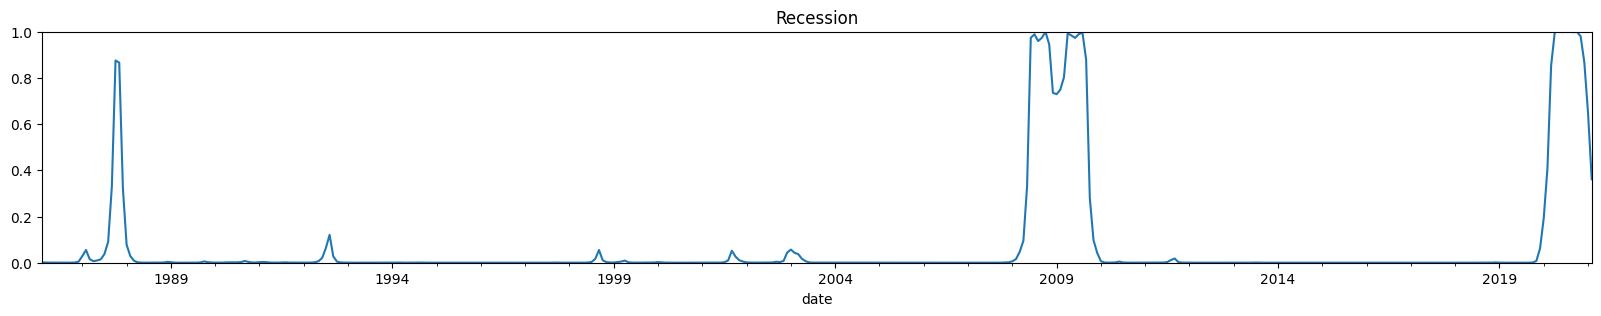

In [13]:
################################################################
####### plot of recession probability
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Create a new DataFrame to store the ratios
date_range_ratios = pd.date_range(start='1986-02', end='2021-03', freq='M')
df_ratios = pd.DataFrame({'date': date_range_ratios, 'ratio': recession.ravel()})
df_ratios.set_index('date', inplace=True)

# Plot the ratio series
df_ratios['ratio'].plot(title="Recession", figsize=(20, 3))
plt.ylim(0, 1)
plt.show()

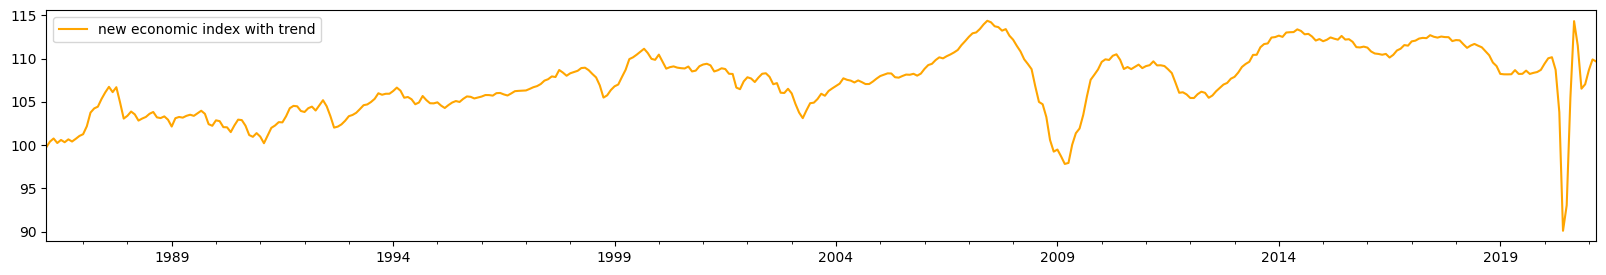

In [14]:
import numpy as np
from numpy.random import normal
N=kalpre.shape[0]
ddelta=np.mean(delta)
C0=99.72203
newCLI = np.zeros((N, 1))
newCLI[0]=C0+(sample_ct/(iter-burn))[0]+ddelta
for i in range(1, N):
    newCLI[i] = newCLI[i-1] +  (sample_ct/(iter-burn))[i]+ddelta # new delta_C_t=delta_c_t+C_{t-1}+delta according to appendix A7
    # Create an array of monthly dates
dates = pd.date_range(start='1986-03-01', end='2021-3-01', freq='MS')

# Create a pandas Series with the data and the dates as index
series1 = pd.Series(data=newCLI.ravel(), index=dates)
fig, ax = plt.subplots(figsize=(10,3))
# Plot the series
series1.plot(figsize=(20,3), legend=False,label='new economic index with trend',color='orange')


# Set the y-axis limits
#ax.set_ylim(97, 102)
plt.legend()
plt.savefig('myplot.png')
plt.show()

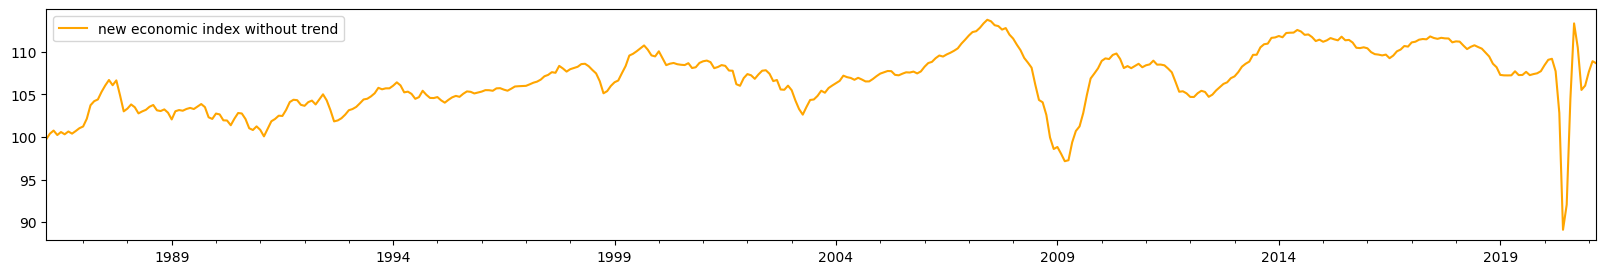

In [15]:
import numpy as np
from numpy.random import normal
N=kalpre.shape[0]
newCLI1 = np.zeros((N, 1))
newCLI1[0]=C0+(sample_ct/(iter-burn))[0]
for i in range(1, N):
    newCLI1[i] = newCLI1[i-1] +  (sample_ct/(iter-burn))[i]# new delta_C_t=delta_c_t+C_{t-1}+delta according to appendix A7
    # Create an array of monthly dates
dates = pd.date_range(start='1986-03-01', end='2021-3-01', freq='MS')

# Create a pandas Series with the data and the dates as index
series1 = pd.Series(data=newCLI1.ravel(), index=dates)
fig, ax = plt.subplots(figsize=(10,3))
# Plot the series
series1.plot(figsize=(20,3), legend=False,label='new economic index without trend',color='orange')


# Set the y-axis limits
#ax.set_ylim(97, 102)
plt.legend()
plt.savefig('myplot.png')
plt.show()

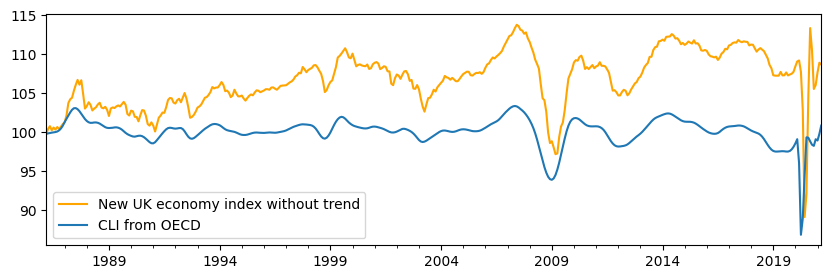

In [16]:
import os
import pandas as pd
import numpy as np
url = 'https://raw.githubusercontent.com/Buchunwang/UK-CLI/main/Kalman%20filter/CLI_raw.csv'#original CLI data
CLI = pd.read_csv(url, header=None, encoding='utf-8', skiprows=1)
# Create an array of monthly dates
dates = pd.date_range(start='1986-03-01', end='2021-3-01', freq='MS')

# Create a pandas Series with the data and the dates as index
series1 = pd.Series(data=newCLI1.ravel(), index=dates)
fig, ax = plt.subplots(figsize=(10,3))
# Plot the series
series1.plot(figsize=(10,3), legend=False,label='New UK economy index without trend',color='orange')

# Create another pandas Series with the same dates as index
series2 = pd.Series(CLI.values.ravel(), index=dates)
# Plot the series

# Plot the second series
series2.plot(figsize=(10,3), legend=False,label='CLI from OECD')



# Set the y-axis limits
#ax.set_ylim(80, 110)
plt.legend()
plt.savefig('myplot.png')
plt.show()
